In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers

print(tf.__version__)


2.1.0


In [2]:
from data_processing import import_and_clean_train, label_encoding

train_X, test_X, train_y, test_y, labels_dict = import_and_clean_train('train', label_encoding)

train_X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,3,108.0,13173,1,1,0,3,0,0,...,0,0,3,4,1,0,11,2009,8,4
1,190,4,50.0,6000,1,1,3,3,0,4,...,0,0,3,4,1,0,11,2009,8,4
2,80,3,73.0,11333,1,1,0,3,0,0,...,0,0,3,4,1,0,5,2007,8,4
3,20,3,71.0,9204,1,1,3,3,0,4,...,0,0,3,4,1,0,8,2008,0,4
4,60,3,59.0,11228,1,1,1,3,0,1,...,0,0,3,4,1,0,12,2008,8,4


In [3]:
# Converting the data to arrays
train_X = np.array(train_X)
train_y = np.array(train_y)
test_X = np.array(test_X)
test_y = np.array(test_y)

Preprocessing: defining the normalizer and adapting it to the train set:

In [4]:
scaler = preprocessing.StandardScaler().fit(train_X)

train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

Function to plot the loss (mean absolute error) at each epoch:

In [10]:
# function used in the train function to plot the cost of the model
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 200000])
    plt.xlabel('Epoch')
    plt.ylabel('Error [SalePrice]')
    plt.legend()
    plt.grid(True)
    plt.show()

# funtion to plot the prediction of the test data
def plot_predictions(model):
    test_predictions = model.predict(test_X).flatten()
    a = plt.axes(aspect='equal')
    plt.scatter(test_y, test_predictions)
    plt.xlabel('True Values [SalePrice]')
    plt.ylabel('Predictions [SalePrice]')
    lims = [0, 500000]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    plt.show()

# funtion to plot the error distribution of the model
def plot_errors(model):
    test_predictions = model.predict(test_X).flatten()
    error = test_predictions - test_y
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error [SalePrice]')
    _ = plt.ylabel('Count')
    plt.show()


Function to train and evaluate a model which layers are defined outside it:

In [7]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.09)

In [5]:
def train_and_evaluate(model, train_x, train_y, val_x, val_y, epochs=100):

    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(lr_schedule), metrics=['msle', 'MAPE'])

    history = model.fit(x=train_X, y=train_y, validation_data=(val_x, val_y), verbose=0, epochs=epochs)

#     plot_loss(history)

    print(f"Train loss: {history.history['loss'][-1]}, val_loss {history.history['val_loss'][-1]}")
    
    print(f"rmsle: {np.sqrt(history.history['msle'][-1])}")
    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'MAPE']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

Preliminary model optimized on training loss:

Train loss: 14685.326626962746, val_loss 18096.357747395832
rmsle: 0.12520214915275574


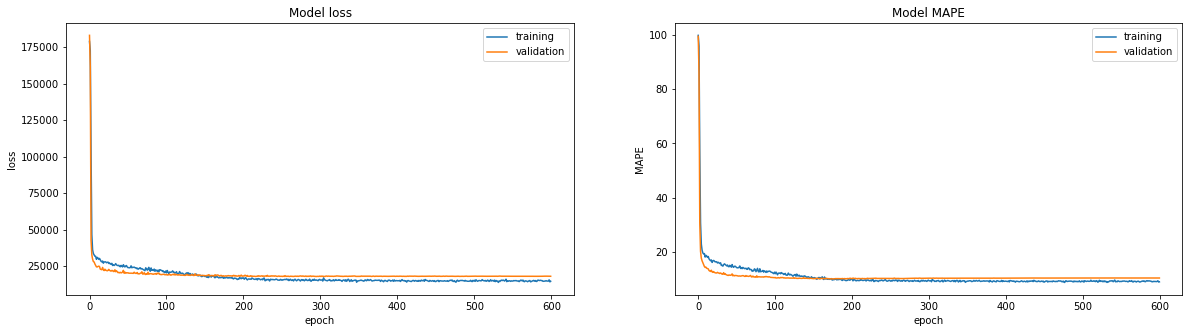

In [8]:
model = models.Sequential()

model.add(layers.Dense(79, activation='relu'))
model.add(layers.Dropout(.5))

model.add(layers.Dense(316, activation='relu'))

model.add(layers.Dense(237, activation='relu'))

model.add(layers.Dense(138, activation='relu'))

model.add(layers.Dense(1))

tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB')

train_and_evaluate(model, train_X, train_y, test_X, test_y, epochs=600)

In [9]:
# Plotting the predictions of the test data based on the model
plot_predictions(model)
plot_errors(model)

NameError: name 'plot_predictions' is not defined

Preliminary model optimized for vallidation loss:

Train loss: 10013.314839163406, val_loss 17005.243574307933
rmsle: 0.11082896590232849


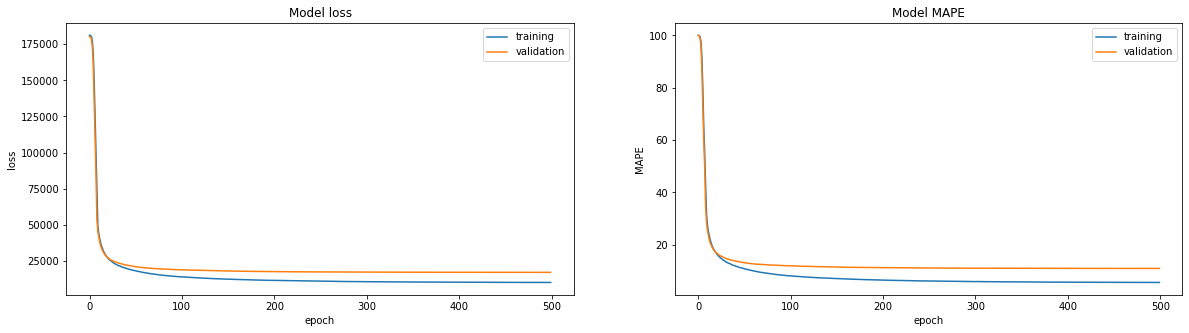

In [10]:
model = models.Sequential()
model.add(layers.Dense(79, activation='relu',
                      kernel_regularizer=regularizers.l2(0.0001)))

model.add(layers.Dense(158, activation='relu',
                      kernel_regularizer=regularizers.l2(0.0001)))

model.add(layers.Dense(79, activation='relu',
                      kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.Dense(1))



train_and_evaluate(model, train_X, train_y, test_X, test_y, epochs=500)

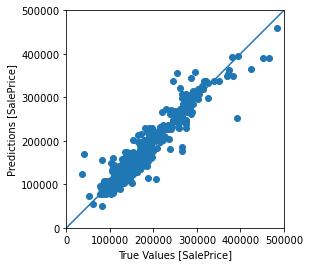

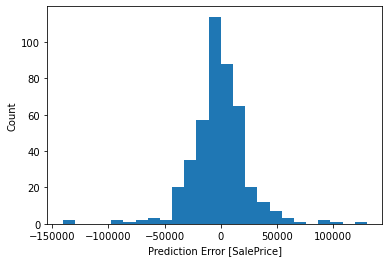

In [11]:
# Plotting the predictions of the test data based on the model
plot_predictions(model)
plot_errors(model)

In [57]:
model = models.Sequential()
model.add(layers.Dense(79, activation='relu'))
model.add(layers.Dropout(.5))

model.add(layers.Dense(316, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(.5))

model.add(layers.Dense(237, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(.5))

model.add(layers.Dense(138, activation='relu'))

model.add(layers.Dense(1))

train_and_evaluate(model, train_X, train_y, test_X, test_y, epochs=600)



KeyboardInterrupt: 

Models for experimentation based on the architecture of the preliminary model:

Train loss: 18043.708231988916, val_loss 19111.21505926724
rmsle: 0.14076702296733856


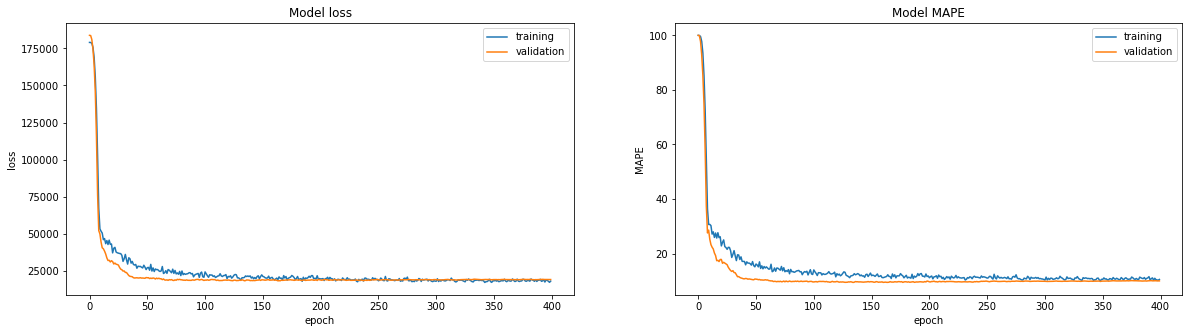

In [11]:
model = models.Sequential()
model.add(layers.Dense(79, activation='relu', 
                       kernel_regularizer=regularizers.l2(0.0001)
                      ))
model.add(layers.Dropout(.5))

model.add(layers.Dense(316, activation='relu', 
                       kernel_regularizer=regularizers.l2(0.0001)
                      ))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(.5))

model.add(layers.Dense(237, activation='relu', 
                       kernel_regularizer=regularizers.l2(0.0001)
                      ))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(.2))

model.add(layers.Dense(138, activation='relu', 
                       kernel_regularizer=regularizers.l2(0.0001)
                      ))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(.2))

model.add(layers.Dense(79, activation='relu',
                       kernel_regularizer=regularizers.l2(0.0001)
                      ))

model.add(layers.Dense(1))

train_and_evaluate(model, train_X, train_y, test_X, test_y, epochs=400)

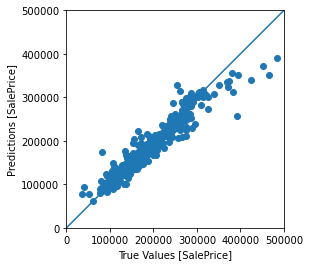

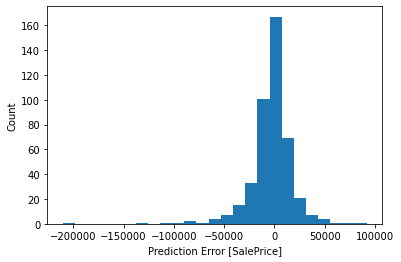

In [15]:
# Plotting the predictions of the test data based on the model
plot_predictions(model)
plot_errors(model)

In [13]:
from data_processing import cleaned_dataframe

df, dicto = cleaned_dataframe('train', encoder=label_encoding)

inputs = df.drop('SalePrice', axis=1)
targets = df.pop('SalePrice')

inputs.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,1,3,3,0,4,...,0,0,3,4,1,0,2,2008,8,4
1,20,3,80.0,9600,1,1,3,3,0,2,...,0,0,3,4,1,0,5,2007,8,4
2,60,3,68.0,11250,1,1,0,3,0,4,...,0,0,3,4,1,0,9,2008,8,4
3,70,3,60.0,9550,1,1,0,3,0,0,...,0,0,3,4,1,0,2,2006,8,0
4,60,3,84.0,14260,1,1,0,3,0,2,...,0,0,3,4,1,0,12,2008,8,4


In [14]:
from sklearn.model_selection import KFold

# Model propetties
# batch_size = 50
epochs = 500

acc_per_fold = []
loss_per_fold = []

# Number of folds
fold_no = 1
num_folds = 5

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
for train_index, test_index in kfold.split(inputs, targets):
    X_train, X_test = np.array(inputs.iloc[train_index]), np.array(inputs.iloc[test_index])
    y_train, y_test = np.array(targets.iloc[train_index]), np.array(targets.iloc[test_index])
    
    model = models.Sequential()

    model.add(layers.Dense(79, activation='relu'))
    model.add(layers.Dropout(.5))

    model.add(layers.Dense(316, activation='relu'))

    model.add(layers.Dense(237, activation='relu'))

    model.add(layers.Dense(138, activation='relu'))

    model.add(layers.Dense(1))
    
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(lr_schedule), metrics=['mean_absolute_error', 'MAPE'])

    history = model.fit(X_train, y_train,
#               batch_size=batch_size, 
                        verbose=0, epochs=300)

#     plot_loss(history)

#     print(f"Train loss: {history.history['loss'][-1]}, val_loss {history.history['val_loss'][-1]}")

    # Generate generalization metrics
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

Score for fold 1: loss of 92780.17917564655; mean_absolute_error of 92780.1796875
Score for fold 2: loss of 91639.11691810345; mean_absolute_error of 91639.109375
Score for fold 3: loss of 82004.41185344827; mean_absolute_error of 82004.40625
Score for fold 4: loss of 81096.5176724138; mean_absolute_error of 81096.515625
Score for fold 5: loss of 85130.9911637931; mean_absolute_error of 85130.984375
